In [2]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from skimage.io import imread, imsave
from skimage.draw import polygon_perimeter, polygon
from skimage.morphology import label, medial_axis, skeletonize
from scipy.ndimage.measurements import center_of_mass
from skimage.draw import bezier_curve
from scipy.ndimage.morphology import binary_fill_holes
from skimage.transform import warp, SimilarityTransform
from skimage.graph import route_through_array
import cv2
import warnings

In [4]:
img1 = 255 - imread('../images/trimmed_queries_divorce/divorce/G/1_extraction_doc_15_line_24_char_36_original_trim.png', as_grey=True) 
img2 = 255 - imread('../images/trimmed_queries_divorce/queries/G/extraction_doc_13_line_7_char_17_original_trim.png', as_grey=True)
img3 = 255 - imread('../images/trimmed_queries_divorce/divorce/G/1_extraction_doc_5_line_35_char_49_original_trim.png', as_grey=True)

In [317]:
def intersection(ima, imb):
    img = ima.copy()
    img[np.where(ima != imb)] = 0
    return img

def union(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 255
    return img

# returns the components of ima that are not in imb
# (i.e., deletes imb from ima)
def difference(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 0
    return img

def create_rectangle(center, height, width, angle, filled = True, shape = (64, 96)):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    corners = np.array([[height/2.0, -1*height/2.0, -1*height/2.0, height/2.0],
                       [width/2.0, width/2.0, -1*width/2.0, -1*width/2.0]])
    corners =  np.transpose(np.matmul(rot_mat, corners) + np.array([[center[0]], [center[1]]])).astype(np.int32)
    
    rect = np.zeros((64, 96), dtype=np.uint8)
    if filled:
        rr, cc = polygon(corners[:,0],
                                   corners[:,1], shape=rect.shape)
    else:
        rr, cc = polygon_perimeter(corners[:,0],
                                   corners[:,1], shape=rect.shape, clip=True)
    rect[rr, cc] = 255
    return rect

def closest_point(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return nodes[np.argmin(dist_2),:].tolist()

def choose_endpts(skeleton, distance):
    skel_pts = np.where(skeleton > 0)
    
    possible_pts = []
    for attempt in range(100):
        rand_index = np.random.choice(range(len(skel_pts[0])), 1)
        end1 = [skel_pts[0][rand_index][0], skel_pts[1][rand_index][0]]
    
        costs = 255 - skeleton + 1
        for i in range(len(skel_pts[0])):
            pt = [skel_pts[0][i], skel_pts[1][i]]
            _, dist = route_through_array(costs, end1, pt, geometric=False)
            if dist == distance:
                possible_pts = possible_pts + [pt]
        if len(possible_pts) > 0:
            break
    end2 = possible_pts[np.random.choice(range(len(possible_pts)), 1)[0]]
    
    return end1, end2

def perpendicular_angle(end1, end2):
    angle = np.arctan2((np.array(end1) - np.array(end2))[0], (np.array(end1) - np.array(end2))[1])
    return [angle + np.pi/2.0, angle - np.pi/2.0]

def random_endpts_angle(end1, end2):
    angle = np.random.choice(perpendicular_angle(end1, end2), 1)
    return angle[0]

def shift_midpoint(end1, end2, angle, dist_shift):
    init_mid = (np.array(end1) + np.array(end2))/2.0
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    new_mid = np.matmul(rot_mat, np.array([[0], [dist_shift]])) + np.array([[init_mid[0]], [init_mid[1]]])
    new_mid = [int(new_mid[0][0]), int(new_mid[1][0])]
    if new_mid[0] < 0:
        new_mid[0] = 0
    if new_mid[0] > 64:
        new_mid[0] = 64
    if new_mid[1] < 0:
        new_mid[1] = 0
    if new_mid[1] > 96:
        new_mid[1] = 96
        
    return new_mid

def bend_skel_with_endpts(skel, end1, end2, dist_shift, angle=None):
    if angle is None:
        angle = random_endpts_angle(end1, end2)
    mid = shift_midpoint(end1, end2, angle, dist_shift)
    
    # delete the points from the path
    path, _ = route_through_array(255 - skel, end1, end2)
    skelnew = skel.copy()
    for pt in path:
        skelnew[pt] = 0
    
    rr, cc = bezier_curve(end1[0], end1[1], mid[0], mid[1],
                        end2[0], end2[1], 2)
    
    skelnew[rr, cc] = 255
    
    return skelnew, angle

def bend_skel(skel, distance, dist_shift):
    end1, end2 = choose_endpts(skel, distance)
    bent, _ = bend_skel_with_endpts(skel, end1, end2, dist_shift)
    return bent

def remove_path(image, orig_skel, new_skel):
    imnew = image.copy()
    path = np.column_stack(np.where(difference(orig_skel, new_skel) > 0)).tolist()
    
    skel_pts = np.column_stack(np.where(orig_skel > 0)).tolist()
    for pt in np.column_stack(np.where(image > 0)).tolist():
        if closest_point(pt, skel_pts) in path:
            imnew[pt[0], pt[1]] = 0
    return imnew

def add_bend(image, orig_skel, bent_skel):
    imnew = remove_path(image, orig_skel, bent_skel)
    new_section = np.column_stack(np.where(difference(bent_skel, orig_skel) > 0)).tolist()
    old_section = np.column_stack(np.where(difference(orig_skel, bent_skel) > 0)).tolist()
    
    _, dist = medial_axis(image, return_distance=True)
    
    for pt in new_section:
        old_pt = closest_point(pt, old_section)
        size = int(dist[old_pt[0], old_pt[1]]) + 1
        imnew = imnew + create_rectangle(pt, size, size, 0)
    
    imnew[np.where(imnew > 0)] = 255
    
    return imnew

def bend_image(image, distance = 13, dist_shift = 9):
    skel = skeletonize(image/255.)*255.
    bent_skel = bend_skel(skel, distance, dist_shift)
    imnew = add_bend(image, skel, bent_skel)
    return imnew

def band_break_image(image, distance = 13):
    skel = skeletonize(image/255.)*255.
    end1, end2 = choose_endpts(skel, distance)
    
    path, _ = route_through_array(255 - skel, end1, end2)
    skelnew = skel.copy()
    for pt in path:
        skelnew[pt] = 0
    
    return remove_path(image, skel, skelnew)


def align_images(image1, image2):
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    # Find size of image1
    sz = image1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION
    warp_matrix = np.eye(2, 3, dtype=np.float32)

    number_of_iterations = 5000

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(image1, image2, warp_matrix, warp_mode, criteria)

    image2_aligned = cv2.warpAffine(image2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    return image2_aligned

def bend_images_same(image1, image2, distance=13, dist_shift=7):
    image2_aligned = align_images(image1, image2)
    skel1 = skeletonize(image1/255.)*255.
    skel2 = skeletonize(image2_aligned/255.)*255.
    
    end1, end2 = choose_endpts(skel1, distance)
    skel2_pts = np.column_stack(np.where(skel2 > 0)).tolist()
    end1_skel2 = closest_point(end1, skel2_pts)
    end2_skel2 = closest_point(end2, skel2_pts)
    
    skel1_bent, angle = bend_skel_with_endpts(skel1, end1, end2, dist_shift)
    skel2_bent, _ = bend_skel_with_endpts(skel2, end1_skel2, end2_skel2, dist_shift, angle)
    
    return add_bend(image1, skel1, skel1_bent), add_bend(image2_aligned, skel2, skel2_bent)

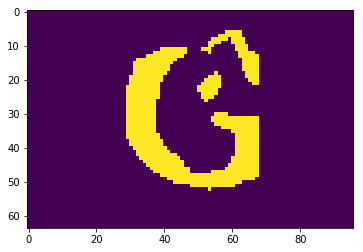

In [8]:
g_files = glob.glob('../images/modified/divorce/G/*.png')
g_array = np.ndarray(shape=(len(g_files), 64, 96))
for ind, f in enumerate(g_files):
    g_array[ind,:,:] = 255 - imread(f, as_grey=True)

In [11]:
r_files = glob.glob('../images/modified/divorce/r/*.png')
r_array = np.ndarray(shape=(len(r_files), 64, 96))
for ind, f in enumerate(r_files):
    r_array[ind, :, :] = 255 - imread(f, as_grey = True)

In [269]:
for ind, f in enumerate(r_files):
    img = r_array[ind,:,:]
    try:
        imnew = (255 - bend_image(img)).astype(int)
        newfile = f.replace('modified', 'broken')
        imsave(newfile, imnew)
    except:
        print ind

849
889


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_10_char_72_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_14_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_29_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_11_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_11_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_38_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_34_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_27_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_14_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_40_char_77_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_28_char_52_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_21_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_10_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_15_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_5_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_8_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_37_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_23_char_69_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_19_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_3_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_10_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_1_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_38_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_37_char_71_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_2_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_18_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_9_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_39_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_22_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_29_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_11_line_12_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_21_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_39_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_22_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_26_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_5_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_25_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_3_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_8_line_20_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_1_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_15_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_23_char_52_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_13_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_17_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_5_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_18_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_1_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_23_char_9_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_18_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_5_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_13_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_20_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_9_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_17_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_7_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_13_line_12_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_8_line_1_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_18_line_32_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_33_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_38_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_9_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_33_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_20_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_16_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_32_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_10_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_0_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_21_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_17_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_7_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_33_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_30_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_25_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_2_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_2_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_21_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_18_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_25_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_15_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_18_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_28_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_13_line_15_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_13_line_17_char_9_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_28_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_15_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_29_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_12_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_22_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_19_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_30_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_23_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_39_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_15_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_17_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_22_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_24_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_34_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_33_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_8_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_34_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_23_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_22_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_16_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_14_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_11_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_28_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_34_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_5_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_24_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_5_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_15_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_27_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_5_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_6_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_27_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_6_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_14_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_17_line_23_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_12_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_32_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_13_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_6_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_4_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_14_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_

1980


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_11_line_23_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_35_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_38_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_3_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_17_line_32_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_4_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_5_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_28_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_18_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_27_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_22_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_6_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_20_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_22_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_37_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_36_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_37_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_9_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_29_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_30_char_41_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_30_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_12_char_68_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_33_char_70_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_33_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_20_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_12_char_67_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_17_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_27_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_20_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_2_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_11_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_34_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_32_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_18_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_28_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_12_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_31_char_76_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_7_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_23_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_36_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_23_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_37_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_20_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_18_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

2362


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_16_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_39_char_71_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_22_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_20_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_24_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_11_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_11_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_30_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_2_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_16_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_29_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_29_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_6_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_7_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_22_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_6_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_32_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_13_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_33_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_11_line_11_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_27_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_27_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_20_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_12_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_25_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_26_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_25_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_11_line_0_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_9_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_3_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_30_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_36_char_67_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_33_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_8_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_35_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_15_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_37_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_9_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_34_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_22_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_1_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_3_char_52_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_20_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_38_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_38_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_2_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_1_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_18_line_6_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_4_line_31_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_4_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_18_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_31_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_13_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_0_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_32_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_15_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_10_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_36_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_22_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_37_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_1_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_38_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_30_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_17_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_14_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_0_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_17_line_31_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_37_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_19_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_25_char_71_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_8_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_39_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_30_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_0_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_28_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_8_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_3_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_19_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_10_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_16_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_25_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_11_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_20_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_24_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_6_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_17_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_5_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_1_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_a

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_1_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_11_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_25_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_23_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_36_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_39_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_5_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_25_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_17_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_32_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_4_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_39_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_8_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_0_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_8_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_24_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_5_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_25_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_6_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_26_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_34_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_15_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_3_char_67_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_30_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_13_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_10_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_17_line_16_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_5_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_14_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_27_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_22_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_6_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_0_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_1_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_7_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_24_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_28_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_14_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_21_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_23_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_36_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_27_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_35_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_2_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_34_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_23_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_16_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_1_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_25_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_0_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_1_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_8_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_a

3595


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_21_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_4_char_41_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_25_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_2_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_36_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_4_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_30_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_37_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_36_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_4_line_18_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_4_line_20_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_26_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_25_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_24_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_11_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_24_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_29_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_4_line_30_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_8_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_32_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_39_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_10_char_75_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_23_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_22_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_30_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_21_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_17_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_31_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_1_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_11_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_19_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_3_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_38_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_19_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_39_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_34_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_30_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_13_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_17_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_2_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_6_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_34_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_5_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_3_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_26_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_36_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_18_char_79_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_18_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_31_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_28_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_16_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_13_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_26_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_19_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_17_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_21_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_17_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_21_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_13_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_10_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_20_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_2_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_36_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_32_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_36_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_8_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_27_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_37_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_7_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_29_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_37_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_17_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_8_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_0_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_11_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_30_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_27_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_35_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_35_char_67_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_16_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_39_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_26_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_12_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_13_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_6_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_38_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_0_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_21_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_37_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_0_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_18_line_38_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_1_char_52_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_38_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_24_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_8_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_25_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_29_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_2_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_19_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_39_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_23_char_69_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_1_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_26_char_52_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_19_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_28_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_1_line_21_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_34_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_29_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

4563


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_9_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_21_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_19_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_9_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_34_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_11_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_25_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_23_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_29_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_14_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_25_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_34_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_9_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_19_char_69_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_30_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_13_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_1_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_18_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_27_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_34_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_21_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_26_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_29_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_27_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_36_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_36_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_11_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_10_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

4811


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_22_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_28_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_35_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_39_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_38_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_7_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_27_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_16_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_35_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_17_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_10_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_29_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_18_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_13_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_23_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_7_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_31_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_12_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_23_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_24_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_3_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_36_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_23_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_27_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_8_char_41_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_14_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_3_char_79_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_2_char_75_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

5054


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_35_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_16_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_15_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_25_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_10_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_25_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_19_char_69_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_1_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

5101


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_6_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_31_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_2_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_8_line_12_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_36_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_7_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_31_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_12_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_27_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_25_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_38_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_18_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_25_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_9_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_1_line_15_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_32_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_17_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_4_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_15_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_35_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_39_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_19_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_35_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_8_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_37_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_4_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_26_char_77_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_8_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_24_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_11_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_26_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_37_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_26_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_39_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_39_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_28_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_37_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_13_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_17_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_10_char_67_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_6_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_33_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_32_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_30_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_36_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_37_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_31_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_22_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_12_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_29_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_34_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_15_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

5551


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_25_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_14_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_29_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_7_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_19_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_22_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_16_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_10_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

5611


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_20_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_8_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_12_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_11_line_14_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_37_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_14_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_33_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_8_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_16_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_32_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_34_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_3_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_9_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_16_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_34_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_24_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_19_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_31_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_2_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_7_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_11_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_6_line_9_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_13_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_19_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_33_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_0_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_31_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_7_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_11_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_38_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_5_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_18_line_20_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_13_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_22_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_23_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_24_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

5903


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_2_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_10_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_24_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_26_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_10_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_12_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_7_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_42_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_31_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_37_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_12_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_3_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_12_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_23_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_1_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_32_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_29_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_42_char_41_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_5_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_16_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_20_char_70_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_3_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_35_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_25_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_1_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_3_char_41_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_32_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_39_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_7_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_18_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_25_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_19_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_25_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_30_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_2_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_9_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_29_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_20_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_39_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_34_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_12_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_39_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_6_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_3_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_26_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_29_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_35_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_15_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_0_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_38_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_13_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_36_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_35_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_27_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_23_char_71_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_38_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_12_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_4_char_79_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_14_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_29_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_10_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_22_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_32_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_18_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_7_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_17_char_41_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_7_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_33_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_30_char_73_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_6_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_30_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_24_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_25_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_24_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_5_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_5_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_26_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_37_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_11_line_24_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_23_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_15_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_19_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_6_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_4_line_21_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_4_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_29_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_39_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_4_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_23_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_16_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_29_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_3_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_25_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_1_line_1_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_35_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_36_char_9_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_26_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_10_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_28_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_11_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

6787


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_2_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_10_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_36_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_37_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_12_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_27_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_22_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_14_line_34_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_6_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_0_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_12_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_33_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_28_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_13_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_39_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_33_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_18_line_17_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_31_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_7_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_4_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_17_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_22_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_27_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_10_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_27_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_7_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_29_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_33_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_31_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_29_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_16_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_18_char_67_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_6_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_12_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_24_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_16_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_29_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_8_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_26_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_8_line_5_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_17_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_4_line_17_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_14_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_13_line_31_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_33_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_23_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_0_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_13_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_37_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_17_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_7_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_16_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_23_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_5_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_36_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_18_line_16_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_15_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_6_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_5_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_2_line_16_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_32_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_25_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_26_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_27_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_16_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_32_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_31_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_30_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_25_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_10_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_28_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_6_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_2_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_13_line_14_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_38_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_12_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

7460


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_18_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_22_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_25_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_30_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_20_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_10_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_23_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_4_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

7520


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_38_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_21_char_74_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_1_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_29_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_36_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_23_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_31_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_27_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_10_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_20_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_12_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_14_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_13_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_25_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_36_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_25_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_13_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_35_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_9_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_36_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

7676


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_16_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_20_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_16_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_25_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_11_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_25_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_5_line_23_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_11_char_9_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_3_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_26_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_40_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_24_char_68_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_18_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_36_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_29_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_19_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_2_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_21_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_21_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_7_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_3_line_2_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_31_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_34_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_8_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_29_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_11_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_23_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_20_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_1_line_2_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_6_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_14_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_13_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_35_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_2_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_33_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_35_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_8_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_18_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_2_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_29_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_6_char_68_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_19_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_36_char_49_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_15_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_31_char_57_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_11_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_26_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_18_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_36_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_13_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_41_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_23_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_0_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_11_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_5_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_38_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_7_line_23_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_17_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_19_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_2_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_16_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_11_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_28_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_13_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_21_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_23_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_30_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_3_line_9_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_15_line_17_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_24_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_0_line_16_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_26_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_12_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_18_line_9_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_0_line_34_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_9_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

8338


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_17_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_22_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_34_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_32_char_46_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_8_line_3_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_2_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_19_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_4_line_27_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_0_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_30_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_2_line_32_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_10_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_25_char_35_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_19_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_23_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_24_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_13_line_19_char_44_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_33_char_5_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_26_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_33_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

8515


/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_43_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_3_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_17_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_28_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_17_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_19_line_23_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_35_char_69_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_34_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_26_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_29_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_4_line_26_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_31_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_1_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_13_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_21_char_42_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_1_line_24_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_33_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_34_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_11_char_68_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_16_line_3_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_22_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_19_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_12_line_28_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_31_char_1_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_19_char_48_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_35_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_6_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_2_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_8_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_12_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_34_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_1_line_19_char_12_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_15_char_52_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_20_char_66_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_30_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_6_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_36_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_1_line_19_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_5_line_15_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_2_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_19_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_30_char_68_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_8_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_39_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_20_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_6_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_30_char_74_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_10_char_41_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_10_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_31_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_18_line_5_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_24_char_58_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_3_line_1_char_60_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_25_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_35_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_8_line_27_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_0_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_9_line_8_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_20_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_25_char_40_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_19_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_2_line_37_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_27_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_5_line_29_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_33_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_15_line_27_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_9_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_5_line_38_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_6_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_0_line_38_char_53_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_18_line_0_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_10_line_0_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_14_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_13_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_1_line_14_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_0_line_33_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_18_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_16_char_39_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_24_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_17_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_17_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_17_line_33_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_16_line_18_char_50_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_5_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_6_line_38_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_25_char_37_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_12_line_16_char_9_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_32_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_13_line_34_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_4_line_39_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_37_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_6_line_28_char_30_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_3_line_2_char_62_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_19_line_33_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_11_line_26_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_8_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_13_line_18_char_10_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_21_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_26_char_26_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_17_char_56_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_10_line_5_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_6_line_28_char_17_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_21_char_67_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_12_line_16_char_4_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_11_line_16_char_9_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_0_line_10_char_65_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_14_line_7_char_38_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_32_char_23_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_9_char_13_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_13_char_11_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_40_char_18_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_13_line_32_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_24_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_39_char_45_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_7_line_25_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_9_line_32_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_7_line_3_char_52_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_12_line_31_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_17_line_6_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_8_line_5_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_19_line_17_char_55_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_1_line_33_char_33_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_4_line_24_char_20_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_2_line_24_char_32_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_6_line_28_char_29_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_18_line_27_char_16_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_13_char_8_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_22_char_6_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_11_line_26_char_27_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_23_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_16_line_28_char_59_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_13_line_28_char_7_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/i

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_10_line_31_char_47_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_5_char_14_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_3_line_20_char_2_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_9_line_36_char_43_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/imag

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_5_char_63_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_39_char_31_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_19_line_19_char_36_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_5_line_29_char_64_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_3_line_3_char_34_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_14_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_11_line_44_char_24_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/3_extraction_doc_17_line_19_char_19_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/im

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_2_line_8_char_28_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_2_char_21_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_4_line_4_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_14_line_7_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_10_line_39_char_3_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/4_extraction_doc_3_line_26_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/1_extraction_doc_9_line_20_char_22_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_16_line_5_char_15_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/ima

/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_15_line_27_char_25_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/0_extraction_doc_14_line_12_char_54_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_15_line_30_char_51_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/image_analysis/scikit-image/skimage/io/_io.py:134: UserWarning: ../images/broken/divorce/r/2_extraction_doc_7_line_19_char_61_original_trim.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ciaran/Documents/other/

In [10]:
%%capture --no-stdout
for ind, f in enumerate(g_files):
    img = g_array[ind,:,:]
    try:
        imnew = (255 - bend_image(img)).astype(int)
        newfile = f.replace('modified', 'broken')
        imsave(newfile, imnew)
    except:
        print ind

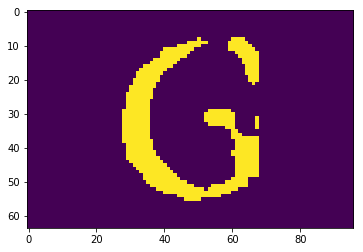

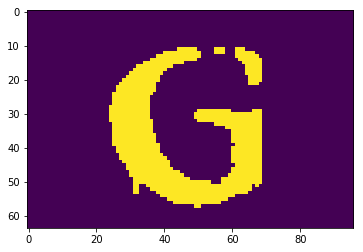

In [520]:
img1 = g_array[np.random.choice(range(g_array.shape[0])),:,:]
img2 = g_array[np.random.choice(range(g_array.shape[0])),:,:]
bent1, bent2 = bend_images_same(img1, img2)
plt.imshow(bent1)
plt.show()
plt.imshow(bent2)
plt.show()

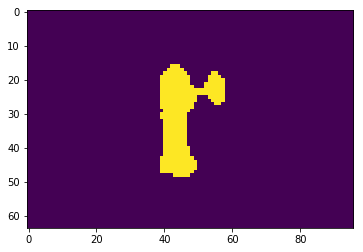

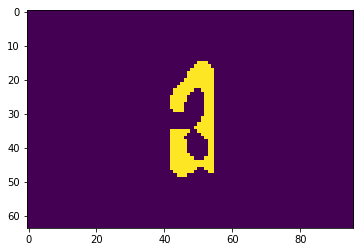

In [412]:
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()